# Nenadgledano učenje


  Nenadgledano učenje je vrsta algoritma mašinskog učenja koji se koristi za kreiranje zaključaka iz skupova podataka koji se sastoje od ulaznih podataka bez označenih odgovora. Najčešća nenadgledana metoda učenja je analiza klastera, koja se koristi za istraživačke analize podataka kako bi se pronašli skriveni paterni ili grupacije podataka.

## Importovanje biblioteka

   Najpre je neophodno importovanje svih potrebnih biblioteka za predprocesiranje dataset-a i algoritme za klasterizaciju.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mpl_toolkits import mplot3d
import matplotlib
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn import neighbors
from sklearn.cluster import DBSCAN
from sklearn import metrics 
import hdbscan
import seaborn as sns
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score


## NBA Dataset

  Izabran je dataset koji vodi statistiku o kosarkaškim utakmicama. Za svakog igrača beleži se:
   * godine,
   * broj utakmica,
   * broj utakmica u kojima je igrač igrao u startnoj petorci,
   * prosečna minutaža po meču,
   * prosečan broj pogođenih šuteva po meču, 
   * prosečan broj šuteva po meču,
   * procenat pogođenih šuteva po meču,
   * prosečan broj pogođenih šuteva za 3p po meču,
   * prosečan broj šuteva za 3p po meču,
   * procenat za 3p po meču,
   * prosečan broj pogođenih šuteva za 2p po meču,
   * prosečan broj šuteva za 2p po meču,
   * procenat za 2p po meču,
   * ukupan procenat za 2p i 3p po meču,
   * prosečan broj pogođenih slobodnih bacanja po meču,
   * prosečan broj slobodnih bacanja po meču,
   * procenat sa linije slobodnih bacanja po meču,
   * prosečan broj skokova u napadu po meču,
   * prosečan broj skokova u odbrani po meču,
   * prosečan broj ukupno skokova po meču,
   * prosečan broj asistencija po meču,
   * prosečan broj ukradenih lopti po meču,
   * prosečan broj izgubljenih lopti po meču,
   * prosečan broj ličnih grešaka po meču,
   * prosečan broj pasova po meču
            
            
            
            
         

In [2]:
dataset = pd.read_csv("nba_2017_br.csv")
del(dataset['Pos'])
del(dataset['Tm'])
X=dataset.iloc[:,2:30].values
X_stability=dataset.iloc[:,2:30]
silluete_labels=[]
algorithms=["kmeans","hc","dbs1","dbs2","hdb1","hdb2","hdb3"]

## Popunjavanje NaN vrednosti u dataset-u

 Korišćen je **SimpleImputer** koji sve NaN vrednosti u dataset-u menja srednjom vrednošću za datu kolonu

In [3]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer=imputer.fit(X)
X=imputer.transform(X)
imputer.fit(X_stability)
X_stability=imputer.transform(X_stability)

## Nalaženje korelacije između atributa

 Kako smo uvideli postojanje logičke povezanosti između određenih atributa, odlučili smo se naći korelaciju između atributa i izbaciti jedan od parova gde je korelacija veća od 0.8. Na taj način broj atributa je smanjen sa 26 na 15.

In [4]:
ds=pd.DataFrame( pd.DataFrame({'Age': X[:, 0],
                               'G': X[:, 1],
                              'GS': X[:, 2],
                              'MP': X[:, 3],
                              'FG': X[:, 4],
                              'FGA': X[:, 5],
                              'FG%': X[:, 6],
                              '3P': X[:, 7],
                              '3PA': X[:, 8],
                              '3P%': X[:, 9],
                              '2P': X[:, 10],
                              '2PA': X[:, 11],
                              '2P%': X[:, 12],
                              'eFG%': X[:, 13],
                              'FT': X[:, 14],
                              'FTA': X[:, 15],
                              'FT%': X[:, 16],
                              'ORB': X[:, 17],
                              'DRB': X[:, 18],
                              'TRB': X[:, 19],
                              'AST': X[:, 20],
                              'STL': X[:, 21],
                              'BLK': X[:, 22],
                              'TOV': X[:, 23],
                              'PF': X[:, 24],
                              'PS/G': X[:, 25]}))


In [5]:
corr = ds.corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm')

,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PS/G
Age,1,0.0601763,0.0186428,0.0712198,0.0155719,0.0249444,0.000773417,0.111468,0.0960975,0.033231,-0.0297767,-0.0219169,-0.000311873,0.0615799,0.0121145,-0.00465385,0.159523,-0.0426285,0.0506703,0.0250985,0.114575,0.049007,-0.0889386,0.0308823,-0.00598931,0.0276212
G,0.0601763,1,0.588545,0.680711,0.559625,0.539339,0.294937,0.403055,0.398012,0.205626,0.502815,0.483697,0.252827,0.366704,0.385798,0.395533,0.183154,0.30193,0.51477,0.476413,0.367152,0.521406,0.293374,0.445462,0.57074,0.541145
GS,0.0186428,0.588545,1,0.818079,0.756525,0.734794,0.229082,0.461076,0.455061,0.118882,0.715291,0.708684,0.174999,0.242218,0.617916,0.634912,0.142262,0.444327,0.669825,0.635822,0.511923,0.633401,0.413522,0.635085,0.61705,0.74329
MP,0.0712198,0.680711,0.818079,1,0.880876,0.884784,0.242785,0.638009,0.642352,0.235375,0.791457,0.799976,0.204011,0.308733,0.699128,0.708896,0.224696,0.381731,0.712404,0.64788,0.645481,0.771258,0.38115,0.754495,0.716667,0.87317
FG,0.0155719,0.559625,0.756525,0.880876,1,0.979059,0.295286,0.61388,0.610285,0.218106,0.943528,0.942162,0.239147,0.316919,0.839948,0.844112,0.233078,0.391688,0.696095,0.638667,0.641707,0.657944,0.393861,0.812118,0.599081,0.987757
FGA,0.0249444,0.539339,0.734794,0.884784,0.979059,1,0.149966,0.693318,0.704553,0.25672,0.885354,0.91639,0.117455,0.204495,0.841203,0.828315,0.293447,0.274129,0.62872,0.551822,0.684068,0.673305,0.293611,0.826477,0.55924,0.983155
FG%,0.000773417,0.294937,0.229082,0.242785,0.295286,0.149966,1,-0.0795315,-0.14173,0.0732645,0.388384,0.277119,0.826627,0.917568,0.166792,0.229549,-0.226877,0.500253,0.383552,0.441472,0.033699,0.158302,0.44944,0.161259,0.376439,0.24004
3P,0.111468,0.403055,0.461076,0.638009,0.61388,0.693318,-0.0795315,1,0.986033,0.515772,0.318493,0.354726,-0.0262736,0.199099,0.488122,0.423733,0.384095,-0.197408,0.222278,0.102711,0.508122,0.494542,-0.0674983,0.496813,0.267735,0.677071
3PA,0.0960975,0.398012,0.455061,0.642352,0.610285,0.704553,-0.14173,0.986033,1,0.466809,0.319717,0.361748,-0.0441453,0.128515,0.504973,0.440214,0.389823,-0.212701,0.223071,0.0984108,0.525581,0.506441,-0.0804979,0.516701,0.267533,0.676924
3P%,0.033231,0.205626,0.118882,0.235375,0.218106,0.25672,0.0732645,0.515772,0.466809,1,0.0456916,0.0746509,-0.0114768,0.334267,0.144549,0.0933468,0.246902,-0.266678,-0.00863929,-0.0903975,0.214458,0.177343,-0.13803,0.145643,0.0226031,0.253613


In [6]:
X_corr=X[:,[0,1,2,6,7,9,10,11,16,17,18,20,21,22,24]].copy()

## KMeans

  **KMeans** algoritam vrši klasterizaciju podatka pokušavajući da razdvoji uzorke u n grupa jednakih varijacija, minimizirajući kriterijum poznat kao inercija ili zbir kvadrata unutar klastera. Ovaj algoritam zahteva da broja klastera bude unapred poznat.Dobro skalira veliki broj uzoraka i korišćen je u velikom rasponu područja primene.
  Algoritam k-means deli skup uzoraka u odvojene klastere, a svaki je opisan sredinom uzoraka u klasteru (engl. mean). Sredine uzoraka se obično nazivaju "centroidi".
  K-znači algoritam ima za cilj da odabere centroide koji umanjuju kriterijum inercije ili unutar klastera, zbirnu vrednost kvadrata
  KMeans ima mnogo nedostaka:
  * Inercija pretpostavlja da su klasteri konveksni i izotropni, što nije uvek slučaj. Loše reaguje na izdužene klastere ili klastere nepravilnih oblika.
  
  * Inercija nije normalizovana metrika: samo znamo da su niže vrednosti bolje, a nula optimalna. Ali u vrlo visokim dimenzijama, euklidske udaljenosti imaju tendenciju da se naduvavaju (ovo je slučaj takozvane „prokletstva dimenzije“). Pokretanje algoritma za smanjenje dimenzija, kao što je analiza glavnih komponenti (PCA) pre klastera k-sredstava, može ublažiti ovaj problem i ubrzati izračunavanja.
  
  Za određivanje broja klastera kosristi se **elbow metod** koji zapravo kreira grafik na kome su označene vrednosti inercije dobijene primenom KMeans-a za 1-10 klastera i bira se onaj broj klastera gde se nalazi pregib.
          

In [7]:
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(X_corr)
    wcss.append(kmeans.inertia_)

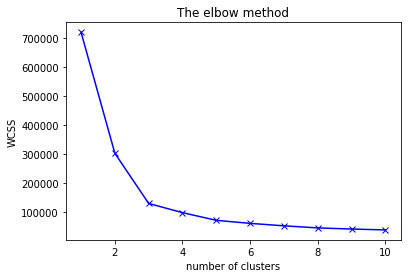

In [8]:
plt.plot(range(1,11), wcss,'bx-')
plt.title("The elbow method")
plt.xlabel("number of clusters")
plt.ylabel("WCSS")
plt.show()

Sa grafika se vidi da je optimalan broj klastera 3, te se za ovu vrednost kreira KMeans.

Kako bismo podatke predstavili vizuelno, koristimo PCA da bismo smanjili dimenzionalnost na 3 i predstavljamo klastere u 3d prostoru.

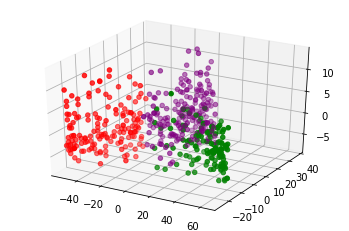

In [9]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_corr)
kmeanModel_pca = KMeans(n_clusters=3, init="k-means++", max_iter=300, n_init=10, random_state=42) 
kmeanModel_pca.fit(X_pca)
pca_pred = kmeanModel_pca.predict(X_pca)
silluete_labels.append(pca_pred)
colors = ["red", "green", "purple"]

fig = plt.figure()
ax = plt.axes(projection="3d")
ax.scatter3D(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=pca_pred, cmap=matplotlib.colors.ListedColormap(colors))
plt.show()

## Hierarchical clustering

 **Hijerarhijsko klasterovanje** je opšta porodica algoritam klastera koji grade ugnježđene klastere njihovim uzastopnim spajanjem ili deljenjem. Ova hijerarhija klastera predstavljena je kao stablo (ili **dendrogram**). Koren stabla je jedinstveni klaster koji skuplja sve uzorke, a listovi su klasteri sa samo jednim uzorkom.
 Objekt AgglomerativeClustering vrši hijerarhijsko grupisanje koristeći pristup odozdo prema gore: svako posmatranje započinje u svom klasteru, a klasteri se uzastopno spajaju zajedno. Kriterijumi za povezivanje određuju metriku koja se koristi za strategiju spajanja.
 Korišćenjem dendogram-a može se naći potimalan broj klastera.

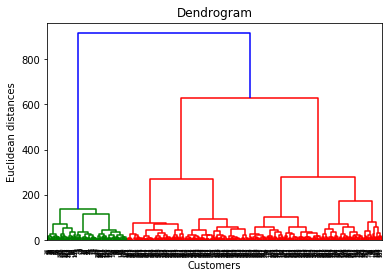

In [10]:
# Using the dendrogram
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(X,metric='euclidean',method='ward'))
plt.title("Dendrogram")
plt.xlabel("Customers")
plt.ylabel("Euclidean distances")
plt.show()

 Kao što se može zaključiti optimalan broj klastera je 3.
 Izvršava se **Agglomerative** klasterizacija za 3 klastera.

In [11]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_corr)
hc = AgglomerativeClustering(n_clusters = 3, affinity='euclidean', linkage='ward')
y_hc = hc.fit_predict(X_pca)
silluete_labels.append(y_hc)
print("Agglomerative Clusters>>>")
print(y_hc)

Agglomerative Clusters>>>
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 0 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 2 0 1 2 1 0 1 1 2 1
 0 2 1 1 1 1 1 1 0 1 2 1 1 1 1 1 1 1 1 1 2 1 1 2 1 2 1 1 1 1 1 2 2 1 1 1 2
 2 1 1 1 0 1 0 1 2 1 1 0 0 1 1 0 1 2 2 0 1 2 2 2 2 1 1 0 1 2 1 2 1 1 2 1 1
 1 1 1 2 2 2 0 2 2 2 1 1 2 2 0 2 2 2 1 2 1 2 1 1 1 2 0 2 0 0 2 2 2 1 1 0 2
 1 0 2 0 2 1 1 1 2 2 0 2 2 0 2 2 2 1 2 2 2 2 0 2 1 2 2 1 1 2 2 2 0 1 2 0 0
 0 1 2 0 1 0 2 2 2 2 2 2 2 1 0 2 1 2 2 1 2 0 0 0 0 2 2 2 2 2 2 0 2 1 1 0 2
 1 0 2 1 2 2 2 2 2 2 2 0 0 2 2 0 0 2 0 1 2 1 2 0 2 2 0 0 0 2 2 1 0 0 2 2 2
 0 0 0 0 0 0 0 2 0 0 2 0 2 2 2 0 0 0 2 0 0 1 0 2 0 2 0 0 0 0 0 2 0 1 0 2 0
 0 2 0 0 1 0 2 0 0 2 0 0 2 2 2 0 2 0 0 2 0 0 0 0 2 0 0 2 0 0 1 0 0 2 0 0 1
 2 0 0 0 0 2 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 2 2
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

    Kako bi se i ova klasterizacija prikazala, ponovo se koristi PCA za smanjenje dimenzionalnosti.

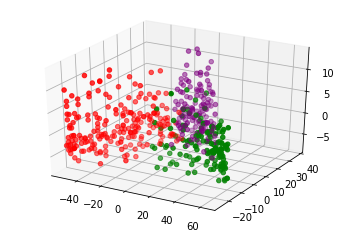

In [12]:
hc = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="ward")
pca_pred = hc.fit_predict(X_pca)
colors = ["red", "green", "purple"]

fig = plt.figure()
ax = plt.axes(projection="3d")
ax.scatter3D(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=pca_pred, cmap=matplotlib.colors.ListedColormap(colors))
plt.show()

Dakle, ukratko:
  * Oslobađali smo se od globularne pretpostavke, ali još uvek pretpostavljamo da svi podaci pripadaju klasterima bez šuma.
  
  * Intuitivni parametri: Slično K-Meansu, zaglavili smo u odabiru broja klastera  ili pokušavamo razumemti neku prirodnu vrednost parametra iz grafikona koji može ili ne mora imati očigledan prirodni izbor.
     
  * Stabilnost: Aglomerativno klasterisanje  je stabilno tokom različitih ciklusa i dendrogram pokazuje kako varira u odnosu na izbor parametara (na relativno stabilan način), pa je stabilnost snažna tačka.
          
  * Performanse: Učinak može biti dobar ako dobijete pravu implementaciju.
     
Još uvek imamo klastere koji sadrže delove nekoliko različitih prirodnih klastera, ali ti 'pogrešni klasteri' su manji. Još uvek imamo sve tačke šuma koje zagađuju naše klastere.

## DBSCAN

  **DBSCAN** je algoritam zasnovan na gustini - pretpostavlja klastere za guste regione. To je ujedno i prvi stvarni algoritam klasterisanja koji smo pogledali: ne zahteva da se svaka tačka dodeljuje klasteru i stoga ne deli podatke, već umesto toga izvlači „guste“ klastere i ostavlja retku pozadinu klasifikovanu kao 'buka'. U praksi se DBSCAN odnosi na aglomerativno klasterisanje.
    Kao prvi korak DBSCAN transformiše prostor prema gustini podataka: tačke u gustim regionima su ostavljene same, dok su tačke u retkim regionima pomerene dalje. Primenom klasterisanja jednostruke veze na transformirani prostor rezultira dendrogramom koji smo izrezali prema parametru udaljenosti (koji se u mnogim implementacijama naziva **epsilon** ili **eps**) kako bismo dobili klastere.
    Važno je da se svi klasteri jednog tipa na tom nivou preseka smatraju „šumom“ i ostave se bez klastera. To pruža nekoliko prednosti: dobijamo mnogostruko ponašanje koje sledi aglomerativno klasterisanje i dobijamo stvarno grupiranje za razliku od podele. Što je još bolje, budući da algoritam možemo uokviriti u pitanje lokalnih regiona, možemo koristiti razne trikove, poput kdtrees-a, da dobijemo izuzetno dobre performanse i skaliranje do veličine podataka koje su inače nedostupne algoritamima koji nisu K-Means. Međutim, postoji nekoliko problema. Ako vaši podaci imaju klastere promenljive gustine, DBSCAN će ih ili propustiti, podeliti ili skupiti neke od njih zajedno, ovisno o vašem izboru parametara.
    
  Očigledno je da je epsilon teško odabrati; Možete napraviti neku analizu podataka i dobro pogoditi, ali algoritam može biti prilično osetljiv na izbor parametra. Transformacija zasnovana na gustini zavisi od drugog parametra (**min_samples**).
        Za kreiranje klastera korišćenjem DBSCAN-a neophodno je pravilno izabrati parametre eps i min_samples. Za odabir parametra eps jedna od metoda je kreiranje grafikona koji određuje k-nn za date podatke. Vrednost koja se uzima je vrednonst pregiba na grafikonu.
        Dok se za odabir vrednosti min_values koriste različite metrike odabira: 4, dim+1, 2xdim 
     
     

In [13]:
from sklearn import neighbors
neigh = neighbors.NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_corr)
distances, indices = nbrs.kneighbors(X_corr)

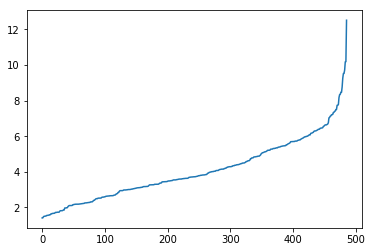

In [14]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

Primer rada DBSCAN-a za eps=8 i min_samples=16 kreiraju se 2 klastera

Silhouette Coefficient: 0.275
2
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 -1 -1  0  0  0 -1 -1  0  0  0  0  0  0  0  1  0  0
  0 -1  0  0  1 -1  0 -1  1  0  0  0  0  0  0  0  1 -1  0  1 -1 -1  0  0
  1 -1  1  1  0  0  0  0  0  0 -1 -1  1  0  0  0  0  0  0  0  0 -1  1  0
 -1  1 -1  1  0  0  0  0 -1  1  1  0 -1  0  1  1  0  0  0  1  0  1 -1  1
 -1  0  1 -1  0  0  1  0  1  1  1 -1  1  1  1  1  0  0  1  0  1  0  1 -1
 -1 -1  0 -1  0 -1  0  1  1  1  1  1 -1  1  0 -1  1  1  1 -1  1  1  0  1
 -1  1  0 -1  0  1  1  1  1  1  1  1  1  0  0 -1 -1 -1 -1  1 -1  1  0 -1
 -1  1  1  1  1 -1  1  1  1 -1  0 -1  1  1  1  1 -1 -1 -1  1 -1 -1  1 -1
  1 -1 -1  1  1 -1  1  0  1  1 -1  1  1 -1 -1  1  1  1  1  0  1  1 -1  1
  1 -1  1  1  1  1  1 -1  1  1  1  1  1 -1 -1  0  0  1  1  0  1  1  0  1
  1  1  1  1  1  1  1  1  1  1 -1  1  1 -1  0  1  0  1  1  1  1  1  1  1
 -1  1  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1
  1  1  1  1  1 -1 

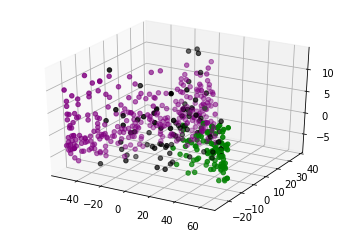

In [15]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_corr)

db = DBSCAN(eps=8, min_samples=16).fit(X_pca)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
silluete_labels.append(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_corr, labels))
print(n_clusters_)
print(labels)
print(set(labels))
colors = ["black", "red", "green", "purple"]


fig = plt.figure()
ax = plt.axes(projection="3d")
ax.scatter3D(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels, cmap=matplotlib.colors.ListedColormap(colors))
plt.show()

Primer rada DBSCAN-a za eps=7.4 i min_samples=22 kreiraju se 3 klastera

Silhouette Coefficient: 0.384
3
[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0 -1  0
  0  0 -1  0  0  0  0 -1 -1  0  0 -1 -1 -1 -1  0  0 -1 -1  0  0  1  0  0
  0 -1 -1 -1 -1 -1  0 -1 -1 -1  0  0  0  0 -1  0 -1 -1 -1 -1 -1 -1  0 -1
  1 -1  2  1  0  0  0  0  0  0 -1 -1  1  0  0  0  0  0  0  0 -1 -1 -1  0
 -1  1 -1 -1  0 -1  0 -1 -1 -1 -1  0 -1  0 -1  1  0  0  0  2  0  1 -1 -1
 -1  0  2 -1  0  0  1  0  1 -1  2 -1 -1 -1  1  1  0  0  2 -1 -1  0 -1 -1
 -1 -1 -1 -1  0 -1  0 -1  1 -1 -1  1 -1 -1  0 -1  1 -1  1 -1 -1 -1  0  1
 -1 -1  0 -1  0 -1 -1  1  2  2  1  1  1  0  0 -1 -1 -1 -1  1 -1 -1  0 -1
 -1 -1  1  1 -1 -1  2 -1  1 -1  0 -1 -1 -1  1  1 -1 -1 -1  1 -1 -1  1 -1
 -1 -1 -1 -1  1 -1  2  0  1 -1 -1  2  1 -1 -1 -1  1  1  1  0  2  1 -1  1
  1 -1  1 -1  2  2  2 -1  1  1  1 -1 -1 -1 -1  0  0  2  1  0  2 -1  0  1
  1  1  1  1  1 -1  2  1  1  1 -1  1  1 -1  0  1  0 -1  1  1 -1  2  2 -1
 -1 -1  0  2  2 -1 -1  1  1  1  2 -1  2  2  2  1  2  1  1 -1  1  1  1 -1
  2  2  1  2 -1 -1 

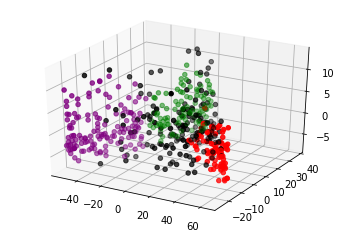

In [16]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_corr)
db = DBSCAN(eps=7.4, min_samples=22).fit(X_pca)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
silluete_labels.append(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_corr, labels))
print(n_clusters_)
print(labels)
print(set(labels))
colors = ["black", "red", "green", "purple"]


fig = plt.figure()
ax = plt.axes(projection="3d")
ax.scatter3D(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels, cmap=matplotlib.colors.ListedColormap(colors))
plt.show()

   Dakle:
   * Klasteri ne moraju biti globularni i neće imati šuma; Klasteri različitih gustine mogu da izazovu probleme, ali to je više u obliku nedovoljnih detalja, nego izričito pogrešnih. 
        
   * Intuitivni parametri: Epsilon je vrednost rastojanja, tako da možete da istražite raspodelu rastojanja u vašem skupu podataka kako biste pokušali da steknete predstavu o tome gde treba da leži. U praksi, međutim, to nije naročito intuitivan parametar, niti je lako pravilno ga izabrati.
        
   * Stabilnost: DBSCAN je stabilan kroz čitave staze, međutim stabilnost u odnosu na različite uzorke epsilona i min_samples nije baš dobra.
        
   * Performanse: Ovo je druga velika snaga DBSCAN-a; nekoliko algoritama za klasterisanje može podneti skupove podataka velikih kao što DBSCAN može.
    
   
        


## HDBSCAN

**HDBSCAN** je nedavni algoritam koji je kreiran od strane tvoraca DBSCAN-a. Njihov cilj je bio da omoguće klastere različitih gustina. Algoritam počinje gotovo isto kao i DBSCAN: transformišemo prostor u skladu sa gustinom, tačno kao što to čini DBSCAN i izvodimo klasterisanje pojedinačnih veza na transformisanom prostoru. Umesto da se za dendrogram uzima vrednost epsilona kao  nivo za podelu, koristi se drugačiji pristup: dendrogram se kondenzuje gledanjem delova koji rezultiraju tako da se mali broj tačaka odvoji kao tačke „ispadaju iz klastera“. To rezultira manjim drvetom s manje klastera koji 'gube tačke'.
    To stablo se zatim može koristiti za izbor najstabilnijih ili najpristupačnijih klastera. Ovaj postupak omogućava sečenje drveta na različitoj visini, odabirom naših klastera različite gustine na osnovu stabilnosti klastera. Neposredna prednost ovoga je da možemo imati klastere različitih gustina; druga prednost je što smo eliminisali parametar epsilona jer nam više ne treba da izaberemo dendrogram. Umesto toga imamo novi parametar **min_cluster_size** koji se koristi da bi se utvrdilo da li tačke 'ispadaju iz klastera' ili se cepaju da bi formirale dva nova klastera. 
    

In [17]:
import hdbscan
hdb = hdbscan.HDBSCAN()
hdb.fit(X_corr)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
        prediction_data=False)

In [18]:
print(hdb.labels_.max())

3


Silhouette Coefficient: 0.101
4
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1 -1 -1  1  1  1 -1 -1  1  1  1  1  1  1  1  3  1  1
  1  1 -1  1  3  0  1 -1  3  1  1  1  1  1 -1  1  3 -1  0  3  1 -1  1  1
  3 -1  3  3  1  1  1  1  1  1  3  0  3  1  1  1  1  1  1  1  1  0  3  1
  3  3 -1  3  1 -1  1  1 -1 -1  3  1  2  1  3  3  1  1  1  3  1  3 -1  3
  3  1  3 -1  1  1  3  1  3  3  3  0  3  3  3  3  1  1  3  1  3  1  3 -1
  2 -1  1  3  1 -1  1  3  3  3  3  3  3  3  1  2  3  3  3 -1  3  3  1  3
  3  3  1  3  1  3  3  3  3  3  3  3  3  1  1 -1  3  0 -1  3 -1  3  1 -1
 -1  3  3  3  3 -1  3  3  3  3  1 -1  3  3  3  3  3  3  3  3  0 -1  3 -1
  3 -1 -1  3  3  3  3  1  3  3  3  3  3 -1  3  3  3  3  3  1  3  3  0  3
  3  2  3  3  3  3  3  3  3  3  3  3  3  3  3  1  1  3  3  1  3  3  1  3
  3  3  3  3  3  3  3  3  3  3 -1  3  3 -1  1  3  1  3  3  3  3  3  3  3
  3  3  1  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3 -1  3  3  3  3
  3  3  3  3 -1  3 

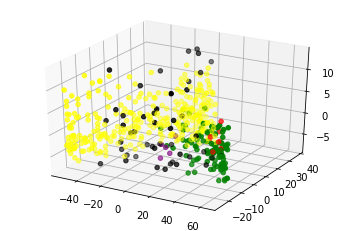

In [19]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_corr)
hdb = hdbscan.HDBSCAN().fit(X_pca)
labels = hdb.labels_
silluete_labels.append(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_corr, labels))
print(n_clusters_)
print(labels)
print(set(labels))
colors = ["black", "red", "green", "purple","yellow"]


fig = plt.figure()
ax = plt.axes(projection="3d")
ax.scatter3D(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels, cmap=matplotlib.colors.ListedColormap(colors))
plt.show()

Silhouette Coefficient: 0.276
5
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 -1  0  0  0  0  0 -1  0  0  0  0  0  0  0  3  0  0
  0  0 -1  0 -1 -1  0  0 -1  0  0  0  0  0  0  0  4 -1 -1  4  0 -1  0  0
  3 -1  2 -1  0  0  0  0  0  0 -1 -1  3  0  0  0  0  0  0  0  0 -1 -1  0
 -1  3 -1 -1  0  0  0  0 -1 -1  4  0 -1  0  4  3  0  0  0  2  0  1 -1  4
 -1  0 -1 -1  0  0  1  0  3  4  2 -1  4  4  3 -1  0  0  2  0  4  0  4 -1
 -1 -1  0 -1  0 -1  0 -1  3 -1 -1  3 -1 -1  0  0  3  4  1 -1 -1  4  0 -1
 -1  3  0 -1  0 -1 -1  3 -1  2  3  3 -1  0  0 -1 -1 -1 -1  3 -1 -1  0 -1
  0  4  3  1  4 -1  2  4  3 -1  0 -1 -1 -1  3  1 -1 -1 -1  3 -1  0  3  3
  4 -1  0  4  1 -1  2  0  3 -1 -1  2  4 -1 -1 -1  3  3  3  0  2  3 -1  3
  3 -1  3 -1  2 -1  2 -1  3  3  3 -1  4 -1 -1  0  0  2  3  0  2  4  0  3
  3  3  3  3  3 -1  2  1  3  3 -1  1  3 -1  0  3  0 -1  1  3  4  2  2  1
 -1  4 -1  2  2  4  3  3  3  1  2  1  2  2  2  3  2 -1  3 -1  3  3  4 -1
 -1  2  3  2 -1 -1 

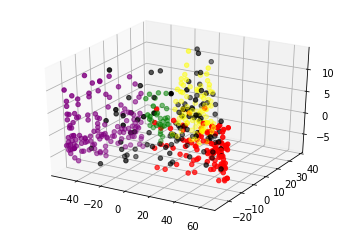

In [29]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_corr)
hdb = hdbscan.HDBSCAN(min_cluster_size=20,min_samples=1 ).fit(X_pca)
labels = hdb.labels_
silluete_labels.append(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_corr, labels))
print(n_clusters_)
print(labels)
print(set(labels))
colors = ["black", "red", "green", "purple","yellow","blue"]


fig = plt.figure()
ax = plt.axes(projection="3d")
ax.scatter3D(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels, cmap=matplotlib.colors.ListedColormap(colors))
plt.show()

HDBSCAN ima mogućnost predstavljanja izgleda hiararhijskog klastera ( koji su klasteri blizu i mogli bi se spojiti,a koji su daleko). Osnovnoj hijerarhiji možemo pristupiti preko atributa **condensed_tree_** objekta klastera.

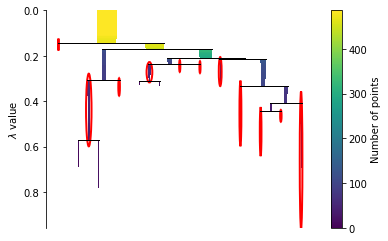

In [21]:
import seaborn as sns
hdb.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 10))

Silhouette Coefficient: 0.277
2
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 -1 -1  0  0  0 -1 -1  0  0  0  0  0  0  0  1  0  0
  0 -1  0  0  1 -1  0 -1  1  0  0  0  0  0  0  0  1 -1  0  1 -1 -1  0  0
  1 -1  1  1  0  0  0  0  0  0  1 -1  1  0  0  0  0  0  0  0  0 -1  1  0
  1  1 -1 -1  0  0  0  0  1  1  1  0 -1  0  1  1  0  0  0  1  0  1 -1  1
 -1  0  1 -1  0  0  1  0  1  1  1 -1  1  1  1  1  0  0  1  0  1  0  1 -1
 -1 -1  0  1  0 -1  0  1  1  1  1  1  1  1  0 -1  1  1  1 -1  1  1  0  1
  1  1  0  1  0  1  1  1  1  1  1  1  1  0  0 -1  1 -1  1  1 -1  1  0  0
 -1  1  1  1  1  1  1  1  1  1  0 -1  1  1  1  1  1  1  1  1  0  0  1  1
  1  1  0  1  1  1  1  0  1  1 -1  1  1  1  1  1  1  1  1  0  1  1 -1  1
  1 -1  1  1  1  1  1  1  1  1  1  1  1 -1  1  0  0  1  1  0  1  1  0  1
  1  1  1  1  1  1  1  1  1  1 -1  1  1 -1  0  1  0  1  1  1  1  1  1  1
  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1 

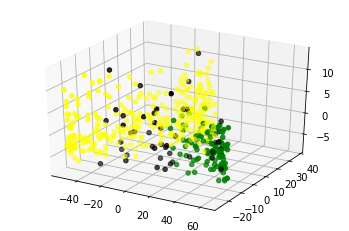

In [22]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_corr)
hdb = hdbscan.HDBSCAN(min_cluster_size=50,min_samples=15 ).fit(X_pca)
labels = hdb.labels_
silluete_labels.append(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_corr, labels))
print(n_clusters_)
print(labels)
print(set(labels))
colors = ["black", "red", "green", "purple","yellow"]


fig = plt.figure()
ax = plt.axes(projection="3d")
ax.scatter3D(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels, cmap=matplotlib.colors.ListedColormap(colors))
plt.show()

Dakle:

* Nasledili smo sve prednosti DBSCAN-a i uklonili problem različitih klastera. HDBSCAN je lako najjača opcija 

* Intuitivni parametri: Izbor veličine mimnimum klastera je vrlo razuman. Jedini preostali parametar su min_samples nasleđen od DBSCAN za transformaciju prostora zasnovane na gustini. Nažalost **min_samples** nije tako intuitivan; HDBSCAN nije tako osetljiv na njega i možemo odabrati neke razumne zadane postavke, ali to je i dalje najveća slabost algoritma.

* Stabilnost: HDBSCAN je stabilan tokom pokretanja i podsampoliranja (pošto će klasteriranje sa promenljivom gustinom i dalje skupiti klastere manjeg podampleta sa istim izborom parametara) i ima dobru stabilnost u odnosu na izbor parametara.

* Performanse: Kada se dobro primeni, HDBSCAN može biti veoma efikasan. Trenutna implementacija ima slične performanse kao aglomerativno klasteriranje.


## Clustering validacija

   Validacija i procena klastera obuhvata tri glavna zadatka:
   * **evaluacija klastera** želi da proceni dobrotu ili kvalitet klastera,
   * **stabilnost klastera** nastoji da razume osetljivost rezultata klastera na različite algoritamske parametre, npr. broj klastera i
   * **tendencija klastera** u prvom redu procenjuje prikladnost primene klasterizacije, tj. da li podaci
imaju bilo kakvu svojstvenu grupisanu strukturu.

Postoji niz mera valjanosti i statistika koja su predložene za svaki od gore navedenih zadataka, a koje se mogu podeliti
u tri glavne vrste:

  1.**Eksterne**:Eksterne validacione mere koriste kriterijume koji nisu inherentni sa dateset-om. To može biti u obliku prethodnog ili stručnog znanja o klasterima, npr. oznake klasa za svaku tačku.
        
  2.**Interne**: Mere interne validacije koriste kriterijume koji su izvedeni iz samih podataka. Na primer, možemo da koristimo udaljenosti unutar klastera i međuklastera da se dobiju mere kompaktnosti klastera (npr. koliko su slične tačke u istom klasteru razdvajanje (npr. koliko su udaljene tačke u različitim klasterim).
        
  3.**Relativne**: Mere relativne validacije imaju za cilj direktno upoređivanje različitih grupa, obično onih dobijenih pomoću različitih podešavanja parametara za isti algoritam.
        

## Mere interne validacije

 Mere interne validacije ne poseduju ground-truth podelu, što je tipičan scenario za grupisanje skupa podataka. Da bi se ocenio kvalitet klastera, interne mere stoga moraju da koriste pojmove unutar klastera,sličnost ili kompaktnost, suprotno idejama razdvajanja među klasterima, obično sa kompromisom u maksimiziranju ova dva cilja.

### Silhouette Coefficient

 Silhouette Coefficient predstavlja primer interne evaluacije, gde veća vrednosti Silhouette Coefficient-a, odgovara modelu sa bolje definisanim klasterima.
 Silhouette Coefficient  definisan je za svaki uzorak i sastoji se od da rezultata:
           a: Srednja udaljenost između uzorka i svih ostalih tačaka u istoj klasi.
           b: Srednja udaljenost između uzorka i svih ostalih tačaka u narednom najbližem klasteru.
 Koeficijent za svaki uzorak se računa kao:
             s=b-a/max(a,b)
 Koeficijent za niz uzoraka se računa kao srednja vrednost izračunatih koeficijenata za svaki uzorak.

[0.5398548090591295, 0.48316428220723195, 0.2746790271151287, 0.3839198314029935, 0.10085542215339817, 0.03546752384866522, 0.27652795975242594]


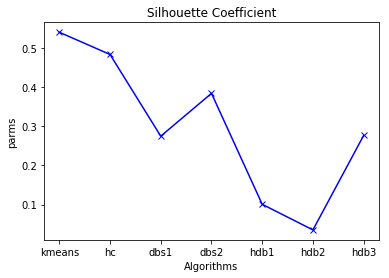

In [23]:
scores=[]
for label in silluete_labels:
    score=metrics.silhouette_score(X_corr,label,metric='euclidean')
    scores.append(score)
print(scores)
plt.plot(algorithms, scores,'bx-')
plt.title("Silhouette Coefficient")
plt.xlabel("Algorithms")
plt.ylabel("parms")
plt.show()

Dobre strane Silhouette Coefficient-a:

  * Rezultat je ograničen između -1 za pogrešno grupiranje i +1 za visoko gusto grupiranje. Rezultati oko nule ukazuju na preklapanje klastera.
  * Rezultat je veći kada su klasteri gusti i dobro razdvojeni, što se odnosi na standardni koncept klastera.
    
Loše strane Silhouette Coefficient-a:

  * Koeficijent siluete generalno je veći za konveksne klastere od ostalih koncepata klastera, kao što su klasteri na osnovu gustine poput onih dobijenih preko DBSCAN.

### Calinski-Harabasz Index

 Takođe poznat kao i  kriterijum za odnos varijanse se koristi za procenu modela gde je veća vrednost indeksa indikator za model sa bolje definisanim klasterima.
 Indeks je odnos sume disperzije između klastera i disperzije unutar klastera za sve klastere (gde je disperzija definisana kao suma kvadratnih rastojanja) 

[1093.6167044979325, 858.4070522478687, 342.79201992792855, 671.6015349867663, 158.2482277056957, 129.7152343687742, 311.7858079913068]


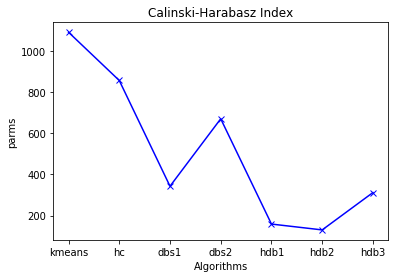

In [24]:
scores=[]
for label in silluete_labels:
    score=metrics.calinski_harabasz_score(X_corr, label)
    scores.append(score)
print(scores)
plt.plot(algorithms, scores,'bx-')
plt.title("Calinski-Harabasz Index")
plt.xlabel("Algorithms")
plt.ylabel("parms")
plt.show()

 Dobre strane Calinski-Harabasz Index-a:

  * Skor je viši kada su klasteri gušći i razdvojeni, što odgovara standardnom koneptu klastera,
  * Skor se brzo izračunava
  
Loše strane Calinski-Harabasz Index-a:
  * Koeficijent Calinski-Harabasz  generalno je više za konveksne klastere od ostalih koncepata klastera, kao što su klasteri na osnovu gustine poput onih dobijenih preko DBSCAN.

### Davies-Bouldin Index

Davies-Bouldin Index je indeks gde manja vrednost indeksa predstavlja model sa boljim odvajanjem između klastera.
Ovaj indeks označava prosečnu 'sličnost' između klastera, pri čemu je sličnost mera koja upoređuje udaljenost između klastera i veličinu samih klastera.
Nula je najmanji mogući rezultat. Vrednosti bliže nuli upućuju na bolju particiju.
    



[0.6247998408736453, 0.6683984212196267, 1.3035979663524218, 0.9430447627859095, 2.250548856384045, 1.146089189703946, 1.3753190086826976]


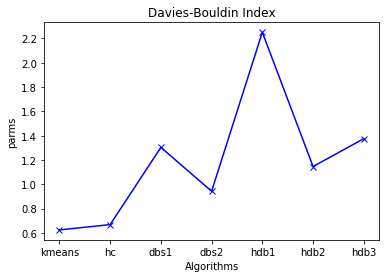

In [25]:
scores=[]
for label in silluete_labels:
    score=davies_bouldin_score(X_corr, label)
    scores.append(score)
print(scores)
plt.plot(algorithms, scores,'bx-')
plt.title("Davies-Bouldin Index")
plt.xlabel("Algorithms")
plt.ylabel("parms")
plt.show()

Dobre strane Davies-Bouldin Index-a:

  * Računanje Davies-Bouldina je jednostavnije od rezultata za Silhouette.
  * Indeks se izračunava samo u količinama i karakteristikama svojstvenim skupu podataka.
  
Loše strane Davies-Bouldin Index-a:

  * Indeks Davies-Boulding opšte je viši za konveksne klastere u odnosu na druge koncepte klastera, poput klastera na osnovu gustine poput onih dobijenih od DBSCAN-a.
  * Upotreba centroidne udaljenosti ograničava metriku udaljenosti na euklidski prostor.